In [1]:
from NOAAStations import TidalStation
from DeviceModels import Turbine, calculate_power
from Calculator import maintenance, operation, installation

import pandas as pd
import os
from ipywidgets import widgets, interact, fixed
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
import scipy
import scipy.interpolate
from contextlib import redirect_stdout
figsize(12, 10)
sbn.set_context("paper", font_scale=1)
sbn.set_style("whitegrid")


from collections import namedtuple


### Testing for the maintenance monte carlo simulation

In [17]:
def harmonicConstituentModel(time, *hm):
    assert len(hm) % 3 == 0
    velocity = 0 
    for i in range(len(hm)//3):
        velocity += hm[3*i]*np.cos((hm[3*i+1] * time + hm[3*i+2])*np.pi/180.)
    return velocity

def calculate_Installation(installations):
    return sum([i.capEx for i in installations])

def calculate_ops(ops, time):
    return(sum([o.annualCost*time for o in ops]))

def richardsCurve(Velocity,B,M,g):
    return 1200*(1+.1835*np.exp(-1*B*(Velocity-M)))**(-1/g)

# def calculate_power(HM, Turbine, p_0, time_start, time_end, gravity, height):
#     '''
#     Integrate the big equation to determine how much power has been generated
#     '''
#     times = np.arange(time_start, time_end)
#     result = odeint(Turbine.instantaneousPower, p_0, times, args=(TidalStation, gravity, height))
#     return result, times

def LevelizedCostofElectricity(HM,
                               number_of_turbines,
                               lifetime, 
                               K, Q, B, M, g,
                               emergency_maintentance,
                               installation,
                               operations):
    
    '''
    This function will calculated the levelized cost of electricity given the parameters for maintenance, power generation, installation
    and lifetime
    station_id will determine the location due to the necessity to use harmonic constituents for the calculations
    grid_location is where the connections will be made
    cap_ex are the capital expenditures for the cost of the turbine and fixtures
    this function was written with a sensitivity analysis in mind
    '''
    
    MCT = Turbine(K, Q, B, M, g)
        
        
    ###
    # The following code is used to run the monte carlo simulation with feedback to the power generation functions
    # where the downtime requires the turbine to no longer generate an output
    ###
    time = []
    results = []
    end_loop = False
    first_loop = True
    time_tracker = 0.
    
    maintenance_costs = []
    maintenance_times = []
    each_maintenance = []
    powerGen = []
    #time to run the simulation
    for i in range(number_of_turbines):
        while not end_loop:
            maintenance_event, uptime = maintenance.monteCarlo(emergency_maintentance)

            if time_tracker + uptime > lifetime:
                end_loop = True
                uptime = lifetime - time_tracker

            end_time = time_tracker + uptime
            results_array , time_array = calculate_power(HM, 
                                                         MCT, 
                                                         0, 
                                                         time_tracker*24*3600*365.25, 
                                                         end_time*24*3600*365.25, 
                                                         ) # everything else is in years, need to convert to seconds for int

            maintenance_costs.append(maintenance_event.event_cost)
            maintenance_times.append(time_tracker+uptime)
            time_tracker += uptime + maintenance_event.downtime.total_seconds()/(24*3600*365.25)
            try:
                results.append(results_array+results[-1][-1])
            except IndexError:
                results.append(results_array)
#             print('{} kJ'.format(results[-1][-1]))

            time.append(time_array)
        
        
        power_tracking = np.concatenate(results)
        powerGen.append(np.concatenate(results)[-1])
        times = np.concatenate(time)
        
        each_maintenance.append(sum(maintenance_costs))
    
    plt.plot(times/(24*3600*365.25), power_tracking)
    plt.show()
    plt.plot(maintenance_times, maintenance_costs)
    plt.show()
    
    installation_cost = calculate_Installation(installation)
    ops_cost = calculate_ops(operations, lifetime)
    # Process the final costs and return the levelized cost
    total_cost = sum(each_maintenance) + installation_cost + ops_cost
    print(total_cost)
    total_power = sum(powerGen)/lifetime/(365.25*24) #to kWhr!!
    print(total_power)
    return total_cost/total_power

In [20]:
Maintenance_Rate = namedtuple('Parameter', 'partname minimal_rate midlevel_rate severe_rate minimal_cost midlevel_cost severe_cost number labor')
CapitalInstallation = namedtuple('Parameter', 'name costPerDay timePerTurbine time numberOfTurbines scalePerTurbine')

## Heli Rate 2000-5000
## Heli Speed = 130-145
## 1014
## 31


emergency_maintenance = [
    Maintenance_Rate('Blade', 0.042, 0.0273, 0.00007, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Others', 0.03, 0.0299, 0.00006, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Gear Box',0.2125, 0.0325, 0.0005, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Electricity Generator', 0.065, 0.0545, 0.0065, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Shaft', 0.002, 0.007, .001, 1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Brake', 0.0153, 0.0325, 0.0025,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Cable', 0.225, 0.09247, 0.000002,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.),
    Maintenance_Rate('Control system', 0.1, 0.1, 0.0001,1014.*24.*1, 1014*24.*4, 3500*24.*5, 1., 3*40.)
]


emergency_events = [maintenance.EmergencyMaintenance(
            e.minimal_rate, 
            e.midlevel_rate, 
            e.severe_rate,
            e.minimal_cost, 
            e.midlevel_cost, 
            e.severe_cost,
            number = e.number, 
            labor = e.labor, 
            partname = e.partname)
            for e in emergency_maintenance]

ops = [
    operation.OperationsCrew('Site Manager', 1, 114750),
    operation.OperationsCrew('Admin Asst', 2, 94500),
    operation.OperationsCrew('Sr. Tech', 3, 126360/3),
    operation.OperationsCrew('Jr. Tech', 6, 219024/6)   
]

HM = []
with open('HM-COD0903-7.txt','r') as myFile:
    for line in myFile:
        amplitude, speed, phase  = line.split(',')
        HM.append(float(amplitude)/.8)
        HM.append(float(speed))
        HM.append(float(phase))

HM = tuple(HM)

# MCT = Turbine(1200., 0.1835, 3.55361367,  2.30706792,  1.05659521)
# Sagamore = TidalStation(8447173)
# results, times = calculate_power(Sagamore, MCT, 0, 0, 365*24*3600, 9.8, 3)
# t = np.arange(0, 50)
# graph2 = harmonicConstituentModel(t, *HM)

# plt.plot(t, graph2, label='Least Squares Fit')
# plt.legend(loc='best')
# plt.xlabel('Time (hours)')
# plt.ylabel('Velocity (m/s)')
# plt.savefig('TidalCurrentHM.png', format='png', transparent=True, bbox_inches='tight')


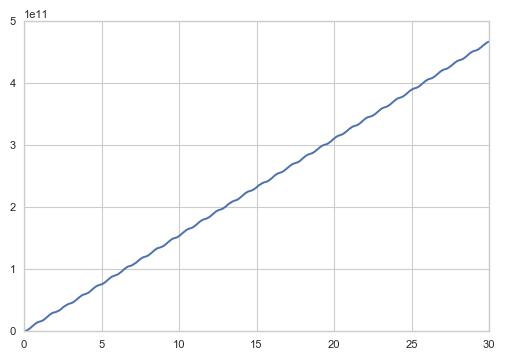

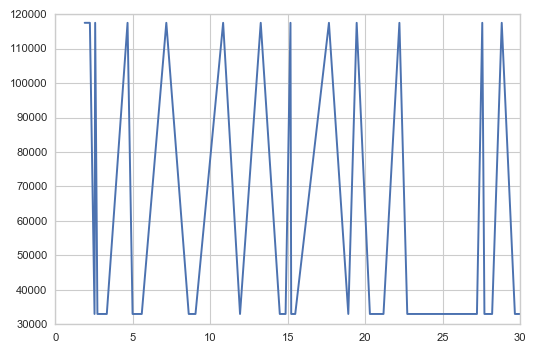

30146696.0
[ 1776072.87445928]


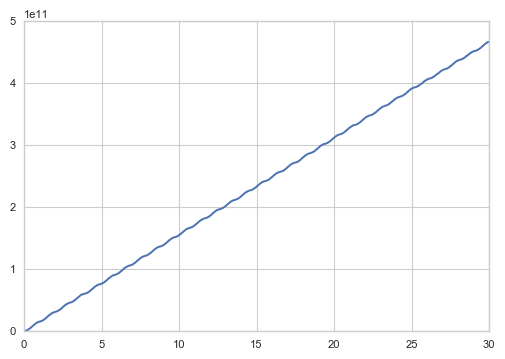

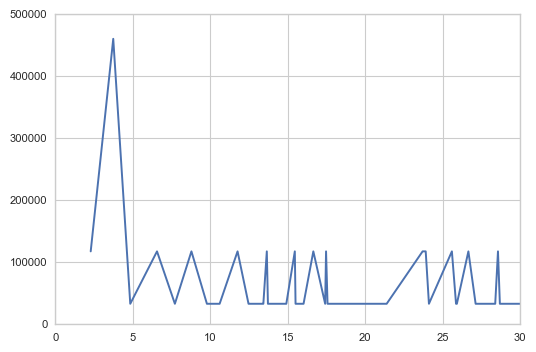

33785916.0
[ 3551242.86825607]


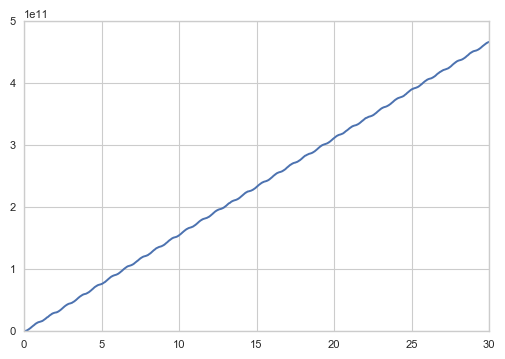

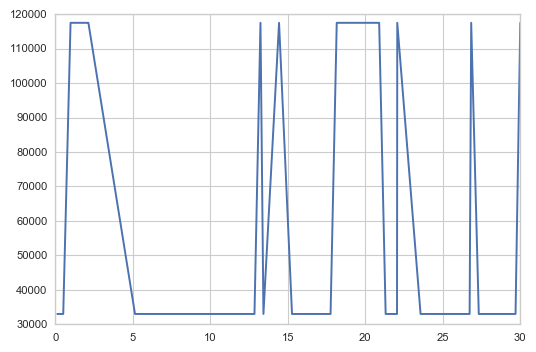

40235640.0
[ 8871735.97295169]


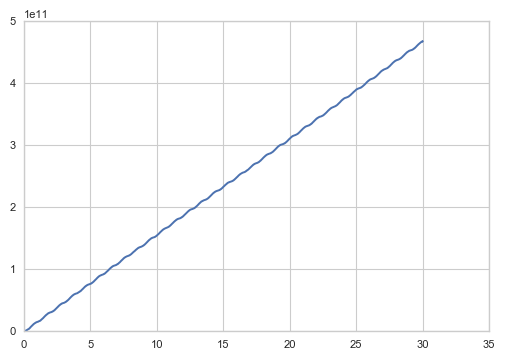

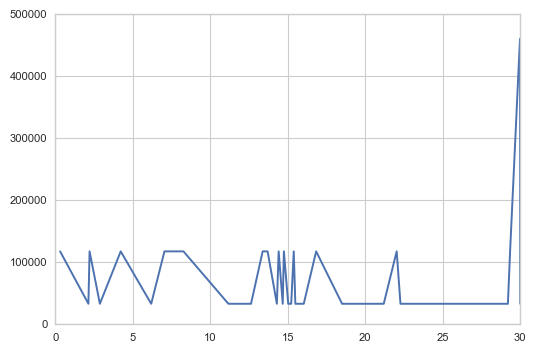

59019260.0
[ 17773811.92069065]


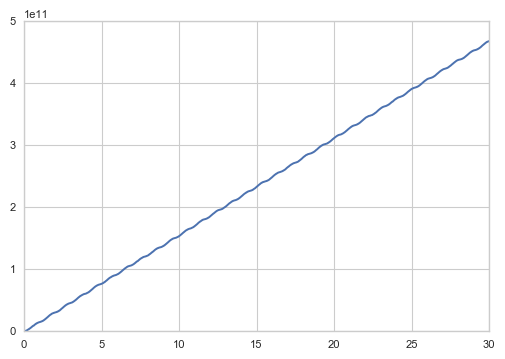

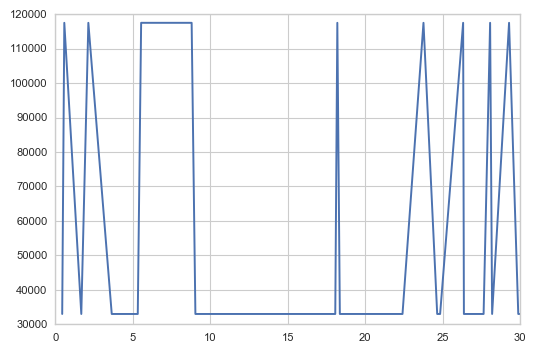

148441020.0
[ 88954491.86236265]


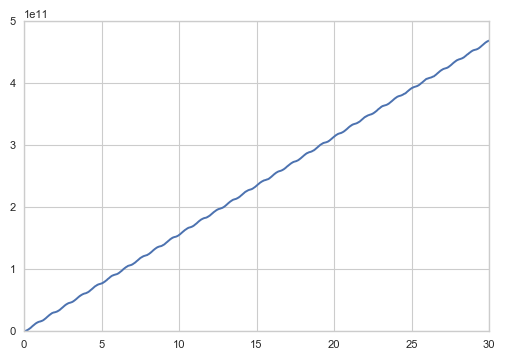

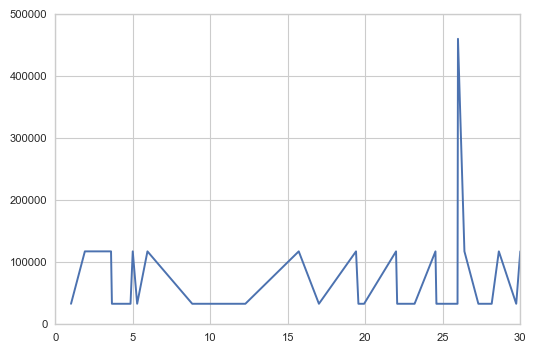

292270820.0
[  1.78206636e+08]
1. SeaGen - [array([ 16.97379451]), array([ 9.51382861]), array([ 4.53526121]), array([ 3.32057413]), array([ 1.6687299]), array([ 1.64006698])]


In [25]:
lifetime = 30.
LCOE = []
for number_of_turbines in [1,2,5,10,50,100]:
    Capital_Installations = [
    CapitalInstallation('Pile Installation, Mobilize Vessel', 111000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Transport', 167000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Drive Piles', 164000., .3, 'n/a', number_of_turbines, True),
    CapitalInstallation('Pile Installation, transport home', 167000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Demobilize', 110000., 'n/a', 3, number_of_turbines, False),
    CapitalInstallation('Gunderboom Sound Barrier', 4500000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Frame for Barrier',50000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Mob/Demob Sound Barrier', 70000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cable transport to site',45000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cables install to device',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable to pile',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable Splicing',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable Fairleading',75000., 'n/a', 5, number_of_turbines, False),
    CapitalInstallation('Cable through HDD', 75000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Cable Burial', 75000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Cable Testing and Commissioning',63000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Cable Transport Home', 45000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cable - Demobilization', 46000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Device Installation, Mobilize Vessel', 74000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Device Installation, Transport to site', 79000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Device Installation, install',  106000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Device Installation, Secure Cables', 106000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Device Installation, Fairleading Cables',  106000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Device Installation, Transport Home', 87000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('FERC Filing Fee', 91000., 'n/a', 1, number_of_turbines, False)]

    installations = [installation.CapitalInstallation(i.name, 
                                                      i.time, 
                                                      i.timePerTurbine, 
                                                      i.costPerDay, 
                                                      i.numberOfTurbines, 
                                                      i.scalePerTurbine)
                                                      for i in Capital_Installations ]

    LCOE.append(LevelizedCostofElectricity(HM, number_of_turbines, lifetime, 1200., 0.1835, 3.55361367,  2.30706792,  1.05659521,
                           emergency_events, installations, ops))
print('1. SeaGen - {}'.format(LCOE))




In [51]:
import plotly.plotly as py
import plotly.graph_objs as go


trace = go.Bar(
    x = ['One','Two','Five','Ten','Fifty','One Hundred'],
    y = LCOE,
    marker = dict(color = 'rgb(52, 165, 218)')
)

layout = go.Layout(
    xaxis = dict(title = 'Number of SeaGen Turbines',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    yaxis = dict(title = 'US $ / kWhr',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
        annotations=[
        dict(x=xi,y=yi,
             text='${0:.2f}'.format(yi[0]),
             font = dict(
                 size = 16,
                 color='white'),
             xanchor='center',
             yanchor='bottom',
             showarrow=False,
        ) for xi, yi in zip(['One','Two','Five','Ten','Fifty','One Hundred'], LCOE)],
    paper_bgcolor='transparent',
    plot_bgcolor='transparent')

fig = go.Figure(data = [trace], layout=layout)
py.iplot(fig, filename='lcoe')

In [27]:
lifetime = 30.
LCOE_gen4wave = []
for number_of_turbines in [1,2,5,10,50,100]:
    Capital_Installations = [
    CapitalInstallation('Pile Installation, Mobilize Vessel', 111000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Transport', 167000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Drive Piles', 164000., .3, 'n/a', number_of_turbines, True),
    CapitalInstallation('Pile Installation, transport home', 167000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Pile Installation, Demobilize', 110000., 'n/a', 3, number_of_turbines, False),
    CapitalInstallation('Gunderboom Sound Barrier', 4500000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Frame for Barrier',50000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Mob/Demob Sound Barrier', 70000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cable transport to site',45000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cables install to device',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable to pile',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable Splicing',75000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Cable Fairleading',75000., 'n/a', 5, number_of_turbines, False),
    CapitalInstallation('Cable through HDD', 75000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Cable Burial', 75000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Cable Testing and Commissioning',63000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Cable Transport Home', 45000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Cable - Demobilization', 46000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Device Installation, Mobilize Vessel', 74000., 'n/a', 4, number_of_turbines, False),
    CapitalInstallation('Device Installation, Transport to site', 79000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('Device Installation, install',  106000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Device Installation, Secure Cables', 106000., .5, 'n/a', number_of_turbines, True),
    CapitalInstallation('Device Installation, Fairleading Cables',  106000., 'n/a', 2, number_of_turbines, False),
    CapitalInstallation('Device Installation, Transport Home', 87000., 'n/a', 1, number_of_turbines, False),
    CapitalInstallation('FERC Filing Fee', 91000., 'n/a', 1, number_of_turbines, False)]

    installations = [installation.CapitalInstallation(i.name, 
                                                      i.time, 
                                                      i.timePerTurbine, 
                                                      i.costPerDay, 
                                                      i.numberOfTurbines, 
                                                      i.scalePerTurbine)
                                                      for i in Capital_Installations ]

    LCOE_gen4wave.append(LevelizedCostofElectricity(HM, number_of_turbines, lifetime, 1150.6, 18.11, 472.55,  2.197,  236.4,
                           emergency_events, installations, ops))

print('2. Gen4Wave V7 - {}'.format(LCOE_gen4wave))

/Users/Cain/Code/Capstone/MHK-LCoE/DeviceModels/power.py:25: RuntimeWarning:

overflow encountered in exp

/Users/Cain/Code/Capstone/MHK-LCoE/DeviceModels/power.py:25: RuntimeWarning:

overflow encountered in double_scalars

/Users/Cain/anaconda2/envs/py3/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



KeyboardInterrupt: 

[[  0.00000000e+000]
 [  4.28982590e+005]
 [  0.00000000e+000]
 ..., 
 [              nan]
 [  6.15378780e-313]
 [              nan]]


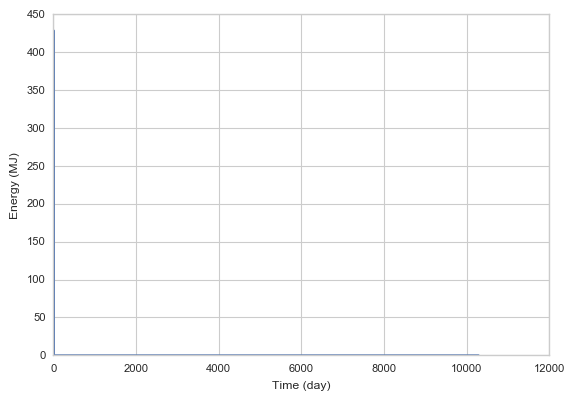

In [7]:
plt.plot(times/(24*3600), results/1000)

plt.ylabel('Energy (MJ)')
plt.xlabel('Time (day)')
plt.savefig('PowerOutput.png', format='png', transparent=True, bbox_inches='tight')

print(results)

### Testing for Maintenance costs

34856000.0


In [ ]:
# lifetime = 30.

# result_list = []
# for i in range(200):
#     result_list.append(maintenance.lifetimeMonteCarlo(lifetime, emergency_events, graph = True))
# for result in result_list:w
#     time, cost = result
#     plt.plot(time, cost)
# plt.xlabel('Time (years)')
# plt.ylabel('Cost (US$)')
# plt.savefig('MonteCarlo.png', format='png', transparent=True, bbox_inches='tight')

### Harmonic Constituents 

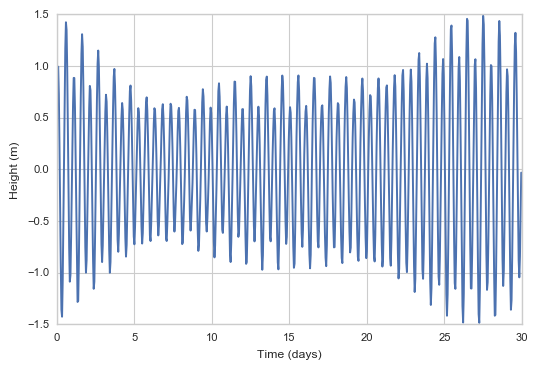

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go

test_station = TidalStation(8447191)
time, height = test_station.predictWaterLevels(0, 24*30)

plt.plot(time/24, height)
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.savefig('HarmonicConstituents.png', format='png', transparent=True, bbox_inches='tight')
# trace = go.Scatter(
#     x = time/24,
#     y = height,
#     mode = 'lines',
#     name = 'lines',
#     line = dict(color = 'rgb(52, 165, 218)')
# )

# layout = go.Layout(
#     title = 'Water Level Height | Bournedale, Cape Cod Canal',
#     titlefont = dict(
#         size = 26,
#         color = 'rgb(131, 135, 135)'),
#     xaxis = dict(title = 'Time (Days)',
#         titlefont = dict(
#         size = 20,
#         color = 'rgb(131, 135, 135)'),
#         tickfont=dict(
#             size=16,
#             color='rgb(131, 135, 135)'
#         )),
#     yaxis = dict(title = 'Height from MLLW (Meters)',
#         titlefont = dict(
#         size = 20,
#         color = 'rgb(131, 135, 135)'),
#         tickfont=dict(
#             size=16,
#             color='rgb(131, 135, 135)'
#         )),
#     paper_bgcolor='transparent',
#     plot_bgcolor='transparent')

# fig = go.Figure(data = [trace], layout=layout)
# py.iplot(fig, filename='harmonicConstituent')

In [ ]:
###
# back calculating harmonic constituents from current measurement values
#
###

import plotly.plotly as py
import plotly.graph_objs as go

def harmonicConstituentModel(time, *hm):
    assert len(hm) % 3 == 0
    velocity = 0 
    for i in range(len(hm)//3):
        velocity += hm[3*i]*np.sin((hm[3*i+1] * time + hm[3*i+2])*np.pi/180.)
    return velocity


station_data = os.path.join('currentData', 'COD0903.pkl')

currents = pd.read_pickle(station_data)
currents.dropna()

currents['COD0903.1.s'] = pd.to_numeric(currents['COD0903.1.s'])
currents['COD0903.1.d'] = pd.to_numeric(currents['COD0903.1.d'])
speedAndDirection = pd.DataFrame(currents['COD0903.1.s'].values/100.*np.cos(currents['COD0903.1.d'].values*np.pi/180.), 
                                 index=currents.index)
                                 
# plt.figure()
# speedAndDirection.plot()
# plt.show()

velocities = speedAndDirection.as_matrix()

time = np.arange(0, len(velocities))*6/60

current_measurements = np.column_stack((time, velocities[:,0]))
current_measurements = current_measurements[~np.isnan(current_measurements).any(axis=1)]

t = np.arange(0, 50, .1)
optimized_parameters = []
with open('HM-COD0903.txt','r') as myFile:
    for line in myFile:
        amplitude, speed, phase  = line.split(',')
        optimized_parameters.append(float(amplitude))
        optimized_parameters.append(float(speed))
        optimized_parameters.append(float(phase))
        
graph2 = harmonicConstituentModel(t, *optimized_parameters)
# plt.plot(data[:500,0], data[:500,1], label='Measured Currents')
# plt.plot(t, graph2, label='Least Squares Fit')
# plt.legend(loc='best')
# plt.xlabel('Time (hours)')
# plt.ylabel('Velocity (m/s)')
# plt.savefig('TidalCurrentHM.png', format='png', transparent=True, bbox_inches='tight')

trace = [go.Scatter(
    x = t,
    y = graph2,
    mode = 'lines',
    name = 'Least Squares Calculation',
    line = dict(color = 'rgb(52, 165, 218)')
    ),
        go.Scatter(
    x = current_measurements[:500,0],
    y = current_measurements[:500,1],
    mode = 'lines',
    name = 'Measured Data',
    line = dict(color = 'white')
    )]

layout = go.Layout(
    title = 'Water Current Velocities | Bournedale, Cape Cod Canal',
    titlefont = dict(
        size = 26,
        color = 'white'),
    xaxis = dict(title = 'Time (hours)',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    yaxis = dict(title = 'Velocity (m/s)',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    paper_bgcolor='transparent',
    plot_bgcolor='transparent')

fig = go.Figure(data = trace, layout=layout)
py.iplot(fig, filename='currentHarmonicConstituent')

### Testing for the power output generation

In [6]:
MCT = Turbine(1200., 0.1835, 3.55361367,  2.30706792,  1.05659521)
Sagamore = TidalStation(8447173)
results, times = calculate_power(Sagamore, MCT, 0, 0, 365*24*3600, 9.8, 3)

plt.plot(times/(24*3600), results/1000)
plt.xlim(0,365)
plt.ylabel('Energy (MJ)')
plt.xlabel('Time (day)')
plt.savefig('PowerOutput.png', format='png', transparent=True, bbox_inches='tight')

TypeError: calculate_power() takes 5 positional arguments but 7 were given

### Build power curve model

In [24]:

import plotly.plotly as py
import plotly.graph_objs as go

def richardsCurve(Velocity,K,Q,B,M,g):
    return K*(1+Q*np.exp(-1*B*(Velocity-M)))**(-1/g)

import scipy.optimize
import numpy as np

velocities = np.array([0,.5,1,1.5,2,2.5,3,3.5,4])
power = np.array([0,20,75,300,800, 1100, 1175, 1195, 1200])

# starting_guess = (1, 1, 1)

# optimized_parameters, covariance = scipy.optimize.curve_fit(richardsCurve, 
#                                                                  xdata = velocities, 
#                                                                  ydata = power, 
#                                                                  p0 = starting_guess)
x = np.linspace(0,4)
y = richardsCurve(x, 1150.6, 18.11, 472.55,  2.197,  236.4)

%matplotlib inline
from matplotlib import pyplot as plt

# plt.plot(x,y)
# plt.ylabel('Power (kW)')
# plt.xlabel('Flow Speed (m/s)')
# plt.savefig('RichardsCurve.png', format='png', transparent=True, bbox_inches='tight')

trace = [go.Scatter(
    x = x,
    y = y,
    mode = 'lines',
    name = 'Richards Curve Model',
    line = dict(color = 'rgb(52, 165, 218)')
    ),
        go.Scatter(
    x = velocities,
    y = power,
    name = 'SeaGen Performance',
    mode = 'markers',
    marker = dict(
        size = 10,
        color = 'white',
        line = dict(
            width = 2,
        )))]


layout = go.Layout(
    title = 'Richards Curve | SeaGen',
    titlefont = dict(
        size = 26,
        color = 'white'),
    xaxis = dict(title = 'Power (kW)',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    yaxis = dict(title = 'Velocity (m/s)',
        titlefont = dict(
        size = 20,
        color = 'white'),
        tickfont=dict(
            size=16,
            color='white'
        )),
    paper_bgcolor='transparent',
    plot_bgcolor='transparent')

fig = go.Figure(data = trace, layout=layout)
py.iplot(fig, filename='RichardsCurve')

/Users/Cain/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning:

overflow encountered in exp



In [13]:
def LevelizedCostofElectricity(station_id, 
                               grid_location,
                               cap_ex,
                               lifetime, 
                               K, Q, B, M, g,
                               h_0,
                               gravity,
                               emergency_maintentance,
                               installation):
    
    '''
    This function will calculated the levelized cost of electricity given the parameters for maintenance, power generation, installation
    and lifetime
    station_id will determine the location due to the necessity to use harmonic constituents for the calculations
    grid_location is where the connections will be made
    cap_ex are the capital expenditures for the cost of the turbine and fixtures
    this function was written with a sensitivity analysis in mind
    '''
    
    MCT = Turbine(K, Q, B, M, g)
    
    tidal_station = TidalStation(station_id)
    
    emergency_events = [maintenance.EmergencyMaintenance(
                e['minimal_rate'], 
                e['midlevel_rate'], 
                e['severe_rate'],
                e['minimal_cost'], 
                e['midlevel_cost'], 
                e['severe_cost'],
                e['minimal_downtime'], 
                e['midlevel_downtime'], 
                e['severe_downtime'],
                e['number'], 
                e['labor'], 
                e['partname'])
                for e in emergency_maintentance]

    #installation_cost = installation.calculateInstallation() 
        
        
    ###
    # The following code is used to run the monte carlo simulation with feedback to the power generation functions
    # where the downtime requires the turbine to no longer generate an output
    ###
    time = []
    results = []
    end_loop = False
    time_tracker = 0.
    
    maintenance_costs = []
    maintenance_times = []
    
    #time to run the simulation
    while not end_loop:
        
        maintenance_event, uptime = monteCarlo(emergency_events)
        
        if time_tracker + uptime > lifetime:
            end_loop = True
            uptime = lifetime - time_tracker
        
        
        end_time = time_tracker + uptime
        results_array , time_array = calculate_power(tidal_station, 
                                                     MCT, 
                                                     results[-1][-1], 
                                                     time_tracker, 
                                                     end_time, 
                                                     gravity, 
                                                     h_0)
        
        maintenance_costs.append(maintenance_event.event_cost)
        maintenance_times.append(time_tracker+uptime)
        time_tracker += uptime + maintenance_event.downtime
        results.append(results_array)
        time.append(time_array)
        
    powerGen = np.concatenate(results)
    times = np.concatenate(time)
    
    
    # Process the final costs and return the levelized cost
    total_cost = maintenance_costs[-1] + installation_cost
    total_power = powerGen[-1]
    return total_cost/total_power

In [ ]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

from SALib.sample.saltelli import sample as ss
from SALib.analyze.sobol import analyze as sa

In [ ]:
Parameter = namedtuple('Parameter', 'name nominal min max description units')
Fixed = namedtuple('Parameter', 'name value description units')
Maintenance = namedtuple('Parameter', 'name nominal min max description units')

parameters_list = [
Parameter('K', 1200.),
Parameter('Q', 0.184),
Parameter('B', 3.554),
Parameter('M', 2.307),
Parameter('g', 1.057),
Fixed('gravity' ,9.8, 'Earth is heavy', '$\frac{m}{s^2}$'),

Maintenance('minimal_rate', 500, 400, 510, 'blade','year^-1'),
Maintenance('midlevel_rate', 3.5, 3, 3.6, 'blade', 'year^-1'),
Maintenance('severe_rate', 3.5, 3, 3.6, 'blade', 'year^-1'),
    ]

parameters_dict = {i.name: i for i in parameters_list}

fixed_parameter_values = {i.name: i.value for i in parameters_list if isinstance(i,Fixed)}

salib_problem = {}
variables = [i for i in parameters_list if isinstance(i,Parameter)]
salib_problem['num_vars']=len(variables)
salib_problem['names'] = [i.name for i in variables]
salib_problem['bounds'] = [[i.min, i.max] for i in variables]
salib_problem['groups'] = None
salib_problem


